In [1]:
"""
# Define pitch
F = [0,1,0] ; E_sharp = [0,1,0]
C = [1,0,1] ; B_sharp = [1,0,1] 
G = [0,-1,2]
D = [-1,0,3]
A = [0,1,4]
E = [1,0,5]  ; F_flat = [1,0,5]
B = [0,-1,6]  ; C_flat = [0,-1,6]
F_sharp = [-1,0,7] ; G_flat = [-1,0,7]
C_sharp = [0,1,8] ; D_flat = [0,1,8]
G_sharp = [1,0,9] ; A_flat = [1,0,9]
D_sharp = [0,-1,10] ; E_flat = [0,-1,10]
A_sharp = [-1,0,11] ; B_flat = [-1,0,11]
"""
print()

In [2]:
import librosa
import os, sys
import numpy as np
from pydub import AudioSegment
from pydub.utils import make_chunks
import warnings
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools
from librosa import display
warnings.filterwarnings('ignore')

/home/hsuan/env1/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
pitch_ary = [[1,0,1], [0,1,8], [-1,0,3], [0,-1,10], [1,0,5], [0,1,0], [-1,0,7],\
                 [0,-1,2], [1,0,9], [0,1,4], [-1,0,11], [0,-1,6]]
pitch_ary = np.array(pitch_ary)

## get all clip 
def get_dirs(path):
    dirs = os.listdir(path)
    return dirs  # file list

## use the list's index to get the corresponding key
def pitch_trans(seq):
    pitch_list = ['C','C#','D','D#(E-)','E','F','F#','G','G#','A','A#(B-)','B']
    return pitch_list[seq]

## transform pitch to array in space
def pitch_to_ary(notes):
    pitch_ary = [[1,0,1], [0,1,8], [-1,0,3], [0,-1,10], [1,0,5], [0,1,0], [-1,0,7],\
                 [0,-1,2], [1,0,9], [0,1,4], [-1,0,11], [0,-1,6]]
    pitch_ary = np.array(pitch_ary)
    return pitch_ary[notes]


## count CE
def count_CE(notes_seq):
    c = Counter(notes_seq)
    Dab = 0
    sum_dp = 0
    for i in range(len(notes_seq)):
        pij = (pitch_to_ary(notes_seq[i]))
        dij = 1
        Dab = sum(c.values())
        sum_dp += (dij * pij)  
        CE = sum_dp/Dab   
    return CE

def get_key(CE, pitch_ary):
    key = []
    for i in range(len(pitch_ary)):
        key.append(abs(pitch_ary[i][0]-int(CE[0])) + abs(pitch_ary[i][1]-int(CE[1])) + \
                  abs(pitch_ary[i][2]-int(CE[2])))
    predict_key = pitch_trans(key.index(min(key)))
    return predict_key

In [4]:
## Analysis chord and pitch

"""
Get how chord changing
key_list: sleeping_key (len = 75)
n_gram: how many chord want to see (1 gram = 1 chord = 4 sec)

"""


def n_gram(key_list, ngram):
    ngram_key = []
    flattened = [val for sublist in key_list for val in sublist]
    for i in range(int(len(flattened)-ngram)):
        ngram_key.append(flattened[i : ngram +i])
    count_ngram = dict([])
    for i in ngram_key:
        i=str(i)
        i = i.replace("[", "")
        i = i.replace("]", "")
        if i in count_ngram:
            count_ngram[i] += 1
        else:
            count_ngram[i] = 1
    return count_ngram 

def n_gram2(key_list, ngram):
    ngram_key = []
#     flattened = [val for sublist in key_list for val in sublist]
    for i in range(int(len(key_list)-3)):
        ngram_key.append(key_list[i : ngram+i])
    count_ngram = dict([])
    for i in ngram_key:
        i=str(i)
        i = i.replace("[", "")
        i = i.replace("]", "")
        if i in count_ngram:
            count_ngram[i] += 1
        else:
            count_ngram[i] = 1
    return count_ngram 

## Get Chord (Unit : 4 beats)

In [5]:
## get all file name
sleeping_music = sorted(get_dirs('./music/sleeping'))
print(len(sleeping_music))

75


In [7]:
sleeping_key = []; pitch = []
def job(num1, num2):
#     for idx in range(len(sleeping_music)):
    for idx in range(num1, num2):
        temp2 = []; temp3 = []
        for d in range(300):
            try:
                y1, sr = librosa.load('./music/sleeping/'+ sleeping_music[idx],offset=4*d,duration = 4, res_type = "kaiser_fast")
                ## onset detection
#                 o_env = librosa.onset.onset_strength(y1, sr=sr)
#                 onset_frames = librosa.onset.onset_detect(y=y1, onset_envelope=o_env, sr=sr)
                o_env = librosa.onset.onset_strength(y1, sr=sr)
                onset_frames = librosa.util.peak_pick(o_env, 7, 7, 7, 7, 0.5, 5)
                ## pitch detection
                b = librosa.feature.chroma_stft(y=y1, sr=sr, n_fft=1024, hop_length=512)

                temp =[]
                for i in range(len(onset_frames)): 
                    temp.append(np.argsort(b[:,onset_frames[i]])[-1])  
                for i in range(len(temp)):
                    temp3.append(pitch_trans(temp[i]))    

                ## count CE
                CE = (count_CE(temp))
                temp2.append(get_key(CE, pitch_ary))
            except:
                pass
        sleeping_key.append(temp2)
        pitch.append(temp3)
    print("Finish")

In [8]:
import threading
import time

## use multi thread to excute

threads = []; threads2 = []; threads3 = []; threads4 = []

threads.append(threading.Thread(target = job, args = (0,75))) 
for t in threads:
    t.start()
    
# threads2.append(threading.Thread(target = job, args = (19,38))) 
# for t2 in threads2:
#     t2.start()
    
# threads3.append(threading.Thread(target = job, args = (38,58))) 
# for t2 in threads3:
#     t2.start()
    
# threads4.append(threading.Thread(target = job, args = (58,75))) 
# for t2 in threads4:
#     t2.start()
 

Finish


In [168]:
## to pickle file
import pickle

with open('key.pkl', 'wb') as f:
    pickle.dump(sleeping_key, f)   
with open('pitch.pkl', 'wb') as f:
    pickle.dump(pitch, f)

with open('key.pkl', 'rb') as f:
    chord = pickle.load(f) 
with open('pitch.pkl', 'rb') as f:
    pitch = pickle.load(f)

In [117]:
len(pitch)

75

## Normalize chord to C major

In [169]:
pitch_list = ['C','C#','D','D#(E-)','E','F','F#','G','G#','A','A#(B-)','B']

## tonal for each songs
tonal = ['E','C#','D','E','X','G','C','G','D','A','X','G','A','B','X','B','C','A','A','E','A','D','C#','A','D','A',
         'E','F#','C','D#(E-)','X','D','X','D','X','B','X','X','X','X','A','X','D','E','G','X','X','X','X','C#','X',
        'D','D','B','X','X','F#','X','C','X','X','X','C#','X','F','D','X','A','X','C','X','X','C#','A','A']

## shift to C major
temp = chord
nor_chord = []
for i in range(75):
    temp_list =[]
    if tonal[i] == 'X':
        pass
    else:
        dist = pitch_list.index(tonal[i])-pitch_list.index('C')  # count shifted distance
        for j in range(len(temp[i])):
            a = pitch_list.index(temp[i][j])-dist
            temp[i][j] = pitch_trans(a)
            temp_list.append(temp[i][j])
        nor_chord.append(temp_list)

# Analysis - Chord

In [171]:
## pitch matching

perfect_five = [['C','G'],['G','D'],['D','A'],['A','E'],['E','B'],['B','F#'],['F#','C#'],['C#','G#'],
                ['G#','D#(E-)'],['D#(E-)','A#(B-)'],['A#(B-)','F'],['F','C']]

same_pitch2 = [['C','C','C'],['D','D','D'],['A','A','A'],['E','E','E'],['B','B','B'],['F#','F#','F#'],
              ['C#','C#','C#'],['G#','G#','G#'], ['D#(E-)','D#(E-)','D#(E-)'],
              ['A#(B-)','A#(B-)','A#(B-)'],['F','F','F'],['G','G','G']]

same_pitch = [['C','C'],['D','D'],['A','A'],['E','E'],['B','B'],['F#','F#'],['C#','C#'],
              ['G#','G#'], ['D#(E-)','D#(E-)'],['A#(B-)','A#(B-)'],['F','F'],['G','G']]

big_three = [['C','E'],['D','F#'],['E','G#'],['F','A'],['G','B'],['A','C#'],['B','D#'],
             ['C#','F'],['D#(E-)','G'],['F#','A#(B-)'],['G#','C'],['A#','D']]

small_three = [['C','D#'],['D','F'],['E','G'],['F','G#'],['G','A#'],['A','C'],['B','D'],
             ['C#','E'],['D#(E-)','F#'],['F#','A'],['G#','B'],['A#','C#']]

four_pitch = [['C','F'],['D','G'],['E','A'],['F','A#(B-)'],['G','C'],['A','D'],['B','E'],
             ['C#','F#'],['D#(E-)','G#'],['F#','B'],['G#','C#'],['A#','D#(E-)']]

whole_tone = [['C','D'],['D','E'],['E','F#'],['F','G'],['G','A'],['A','B'],['B','C#'],
             ['C#','D#(E-)'],['D#(E-)','F'],['F#','G#'],['G#','A#'],['A#','C'],
             ['D','C'],['E','D'],['F#','E'],['G','F'],['A','G'],['B','A'],['C#','B'],
             ['D#(E-)','C#'],['F','D#(E-)'],['G#','F#'],['A#','G#'],['C','A#']]

In [172]:
## if need flattern: flattened = [val for sublist in sleeping_key for val in sublist]
def count_pattern(data,a,b,c):  # a,b,c is scalar
    perfect = 0; same = 0; non = 0; big3 = 0; small3 = 0; four = 0; whole = 0
    perfect_ = 0; same_ = 0; non_ = 0; big3_ = 0; small3_ = 0; four_= 0; whole_ = 0
    for i in range(int((len(data)-a)/a)):
        if data[i*a+b:i*a+c] in perfect_five:
            perfect = perfect+1
        elif data[i*a+b:i*a+c] in big_three:
            big3 = big3+1
        elif data[i*a+b:i*a+c] in small_three:
            small3 = small3+1
        elif data[i*a+b:i*a+c] in same_pitch:
            same = same+1
        elif data[i*a+b:i*a+c] in four_pitch:
            four = four+1
        elif data[i*a+b:i*a+c] in whole_tone:
            whole = whole+1
        else:
            non = non+1
        try:
            perfect_ = round(perfect/int(len(data)/a) *100,2)
            same_ = round(same/int(len(data)/a) *100,2)
            non_ = round(non/int(len(data)/a) *100,2)
            big3_ = round(big3/int(len(data)/a) *100,2)
            small3_ = round(small3/int(len(data)/a) *100,2)
            four_ = round(four/int(len(data)/a) *100,2)
            whole_ = round(whole/int(len(data)/a) *100,2)
        except:
            pass
    return perfect_, same_, non_ , big3_ , small3_ ,four_, whole_

### Chord progression in all dataset

In [213]:
def plt_bar(dictionary, color):
    plt.bar(range(len(dictionary)),list(dictionary.values()) , align='center', color =color)
    plt.xticks(range(len(dictionary)), list(dictionary.keys()))
    plt.show()

Perfect 5: 18.31 %
Big three: 1.82 %
Small 2.94 %
Stable: 26.01 %
Four: 19.21 %
WholeTone: 15.02 %
Other 16.68 %


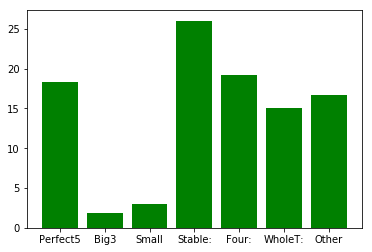

In [214]:
flattened = [val for sublist in nor_chord for val in sublist]
perfect_, same_, non_ , big3_ , small3_ ,four_, whole_ = count_pattern(flattened,1,0,2)
print("Perfect 5:", perfect_, '%')
print("Big three:",big3_, '%')
print("Small",small3_, '%')
print("Stable:",same_, '%')
print("Four:",four_, '%')
print("WholeTone:",whole_, '%')
print("Other",non_, '%')
dict1 = {"Perfect5": perfect_,
         "Big3":big3_, 
         "Small":small3_, 
         "Stable:":same_, 
         "Four:":four_, 
         "WholeT:":whole_, 
         "Other":non_, 
}

plt_bar(dict1, 'g')

### Intra phrase - Chord progression in each songs

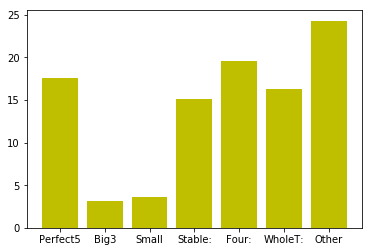

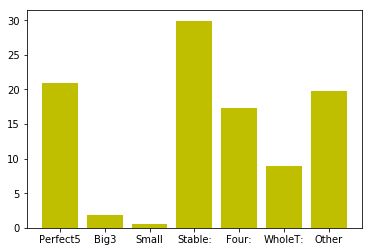

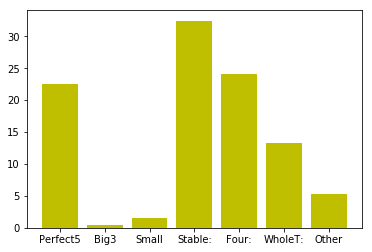

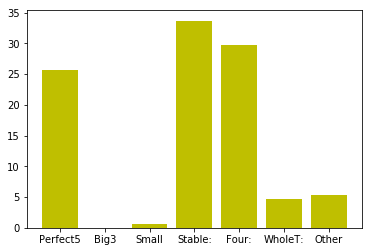

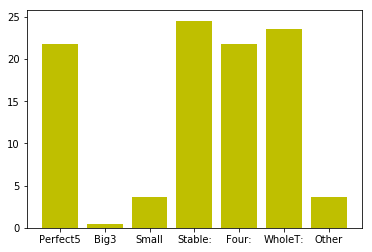

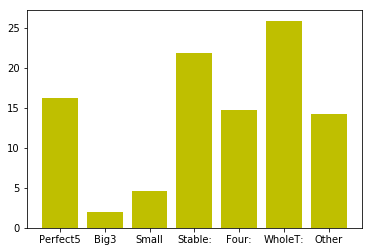

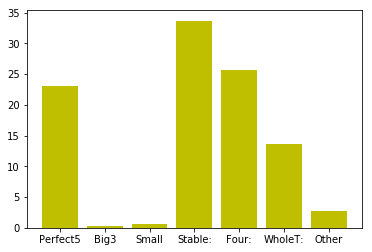

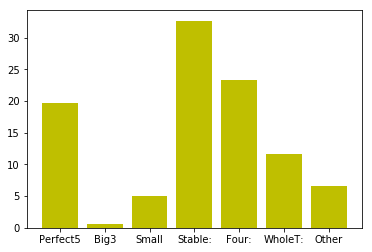

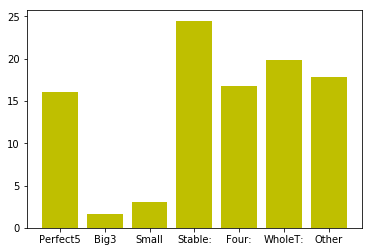

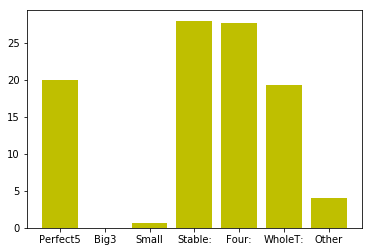

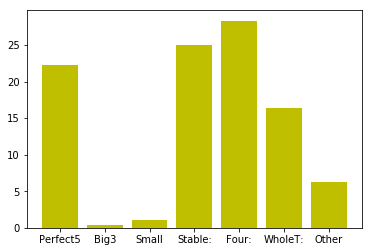

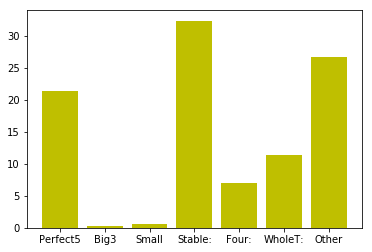

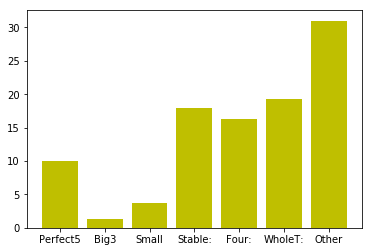

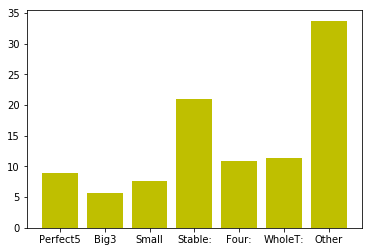

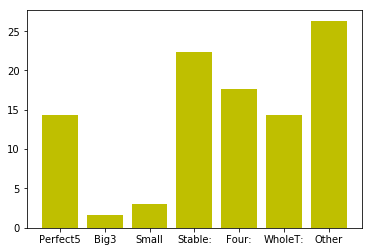

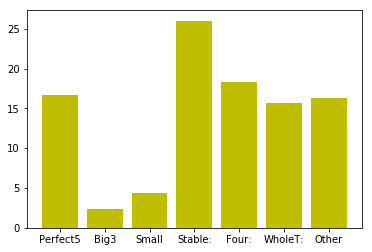

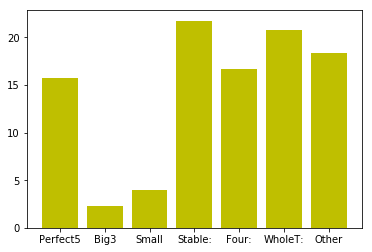

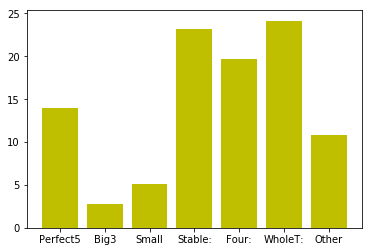

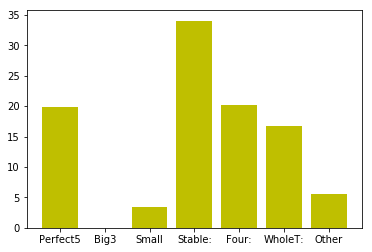

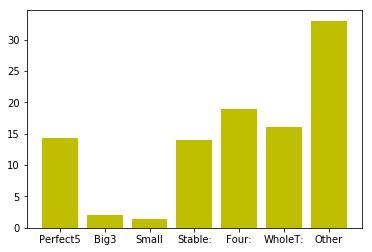

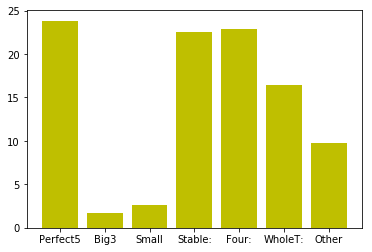

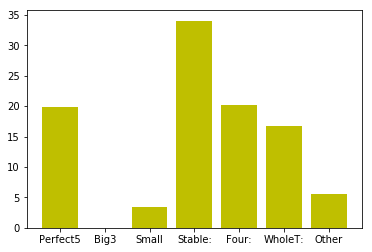

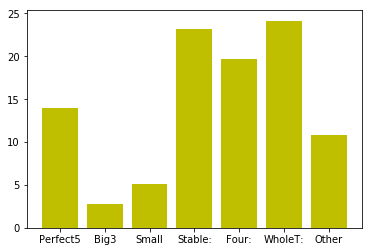

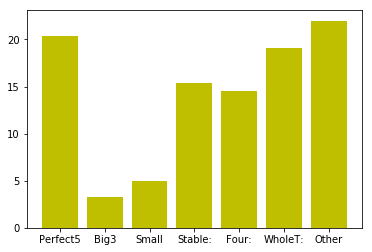

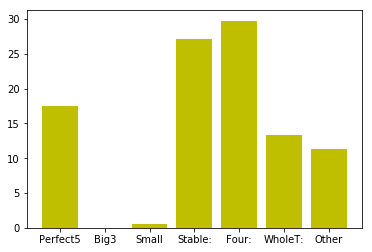

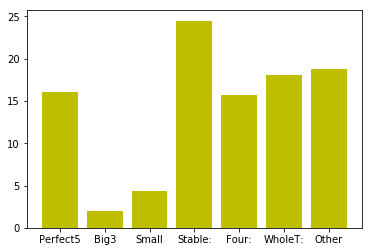

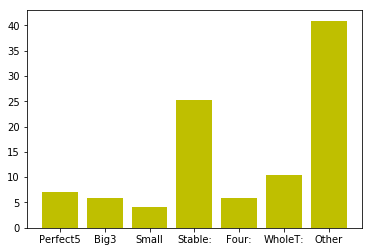

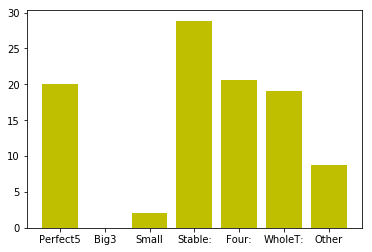

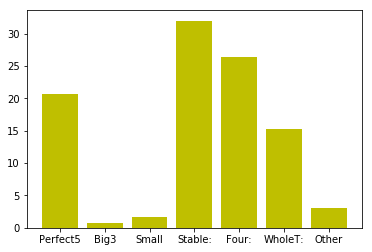

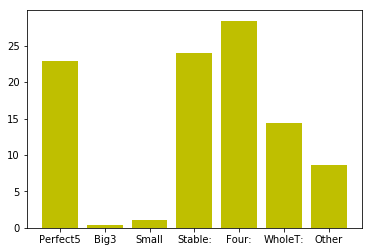

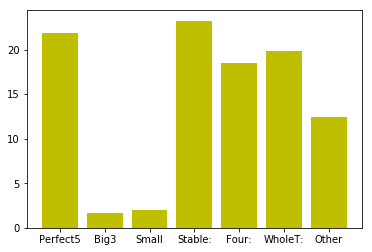

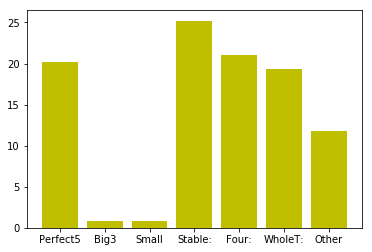

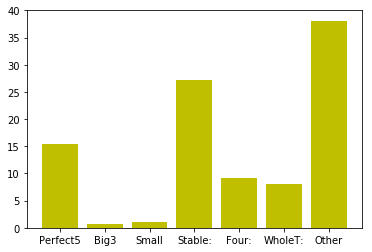

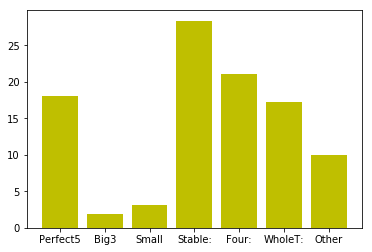

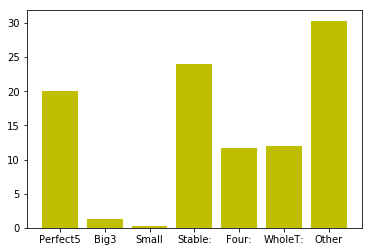

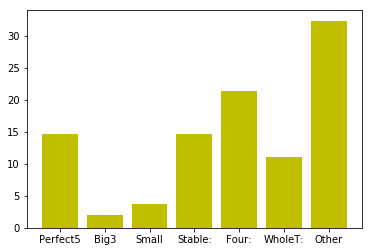

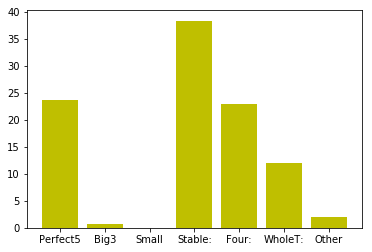

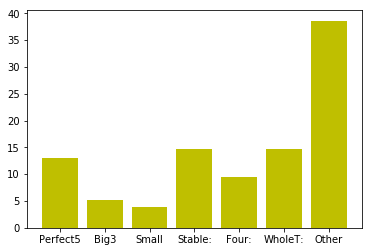

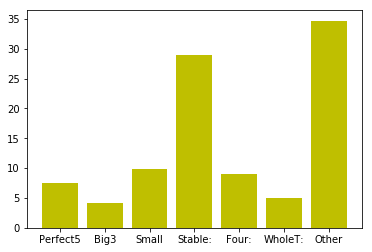

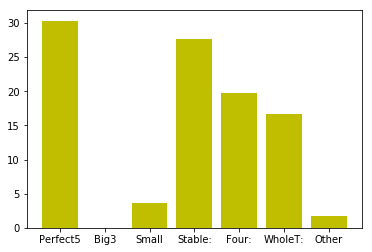

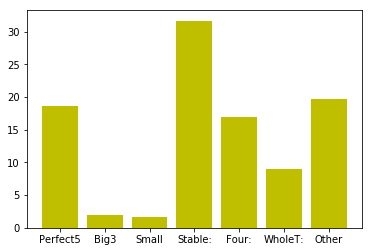

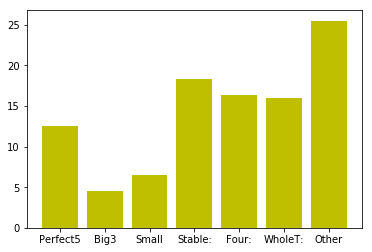

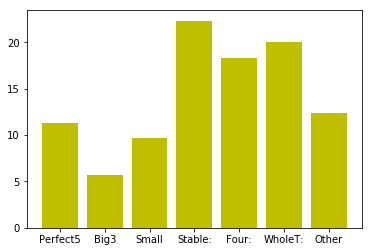

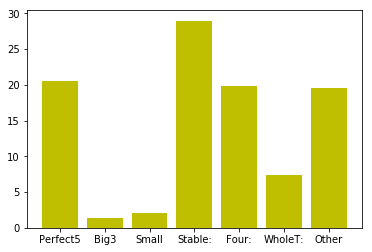

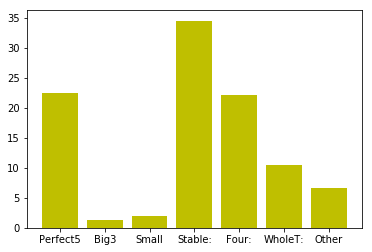

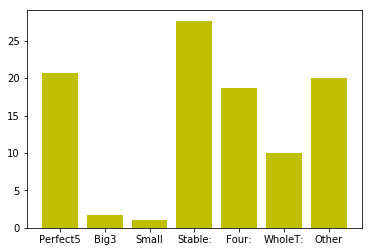

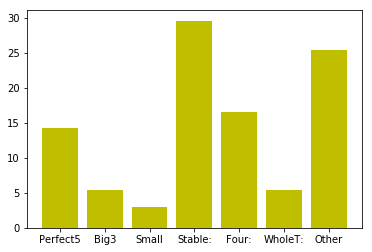

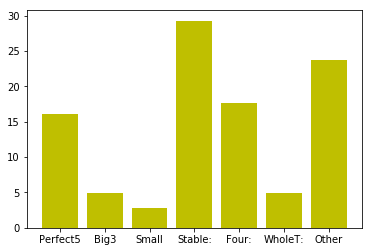

In [215]:
for idx in range(len(nor_chord)):
    perfect_, same_, non_ , big3_ , small3_ ,four_, whole_ = count_pattern(nor_chord[idx],1,0,2)
#     print(idx,sleeping_music[idx])
#     print("Perfect 5:", perfect_, '%')
#     print("Big three:",big3_, '%')
#     print("Small",small3_, '%')
#     print("Stable:",same_, '%')
#     print("Four:",four_, '%')
#     print("WholeTone:",whole_, '%')
#     print("Other",non_, '%')
#     print()
    dict1 = {"Perfect5": perfect_,
             "Big3":big3_, 
             "Small":small3_, 
             "Stable:":same_, 
             "Four:":four_, 
             "WholeT:":whole_, 
             "Other":non_, 
    }
    plt_bar(dict1, 'y')

### Inter phrase - Chord progression between phrase

In [227]:
# flattened = [val for sublist in sleeping_key for val in sublist]
# for i in range(len(nor_chord)):
#     perfect_, same_, non_ , big3_ , small3_ ,four_, whole_ = count_pattern(nor_chord[i],4,3,5)
# #     print("Perfect 5:", perfect_, '%')
# #     print("Big three:",big3_, '%')
# #     print("Small",small3_, '%')
# #     print("Stable:",same_, '%')
# #     print("Four:",four_, '%')
# #     print("WholeTone:",whole_, '%')
# #     print("Other",non_, '%')
# #     print()
#     dict1 = {"Perfect5": perfect_,
#                  "Big3":big3_, 
#                  "Small":small3_, 
#                  "Stable:":same_, 
#                  "Four:":four_, 
#                  "WholeT:":whole_, 
#                  "Other":non_, 
#         }
#     plt_bar(dict1, 'b')

# Analysis - Pitch

### Find dominant pitch

0


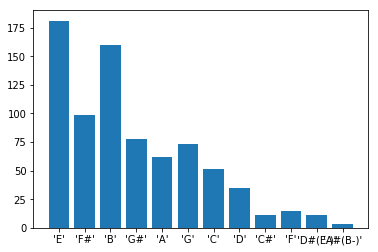

1


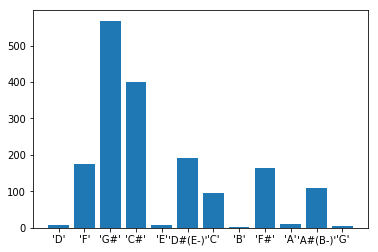

2


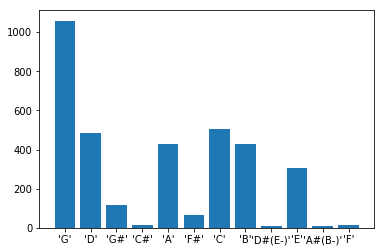

3


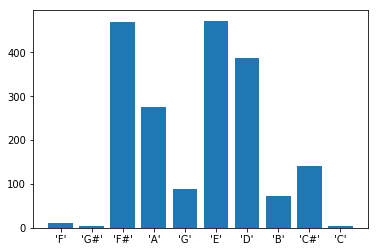

4


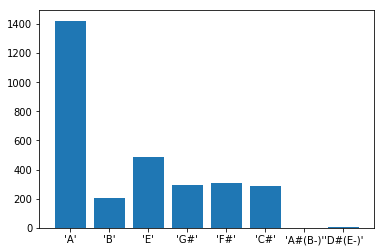

5


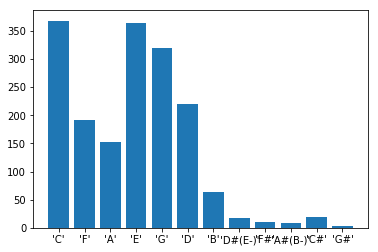

6


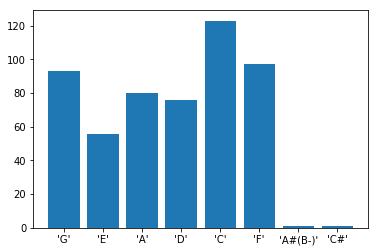

7


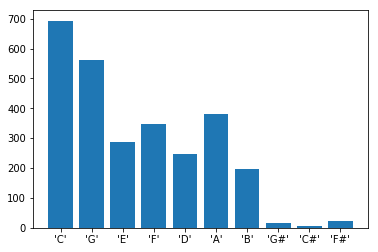

8


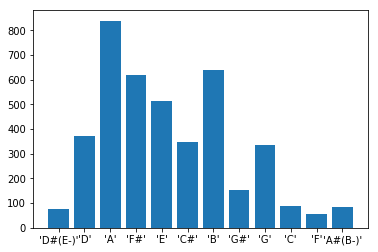

9


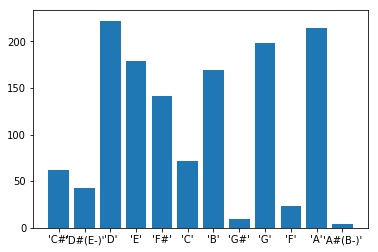

10


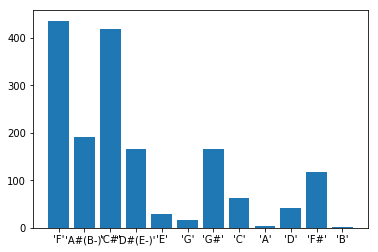

11


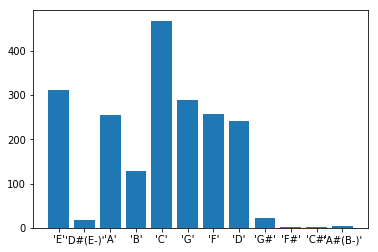

12


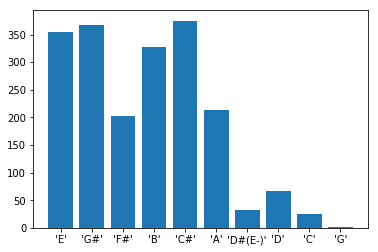

13


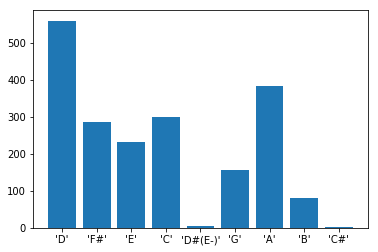

14


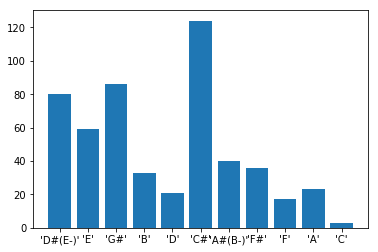

15


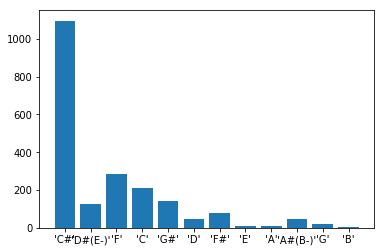

16


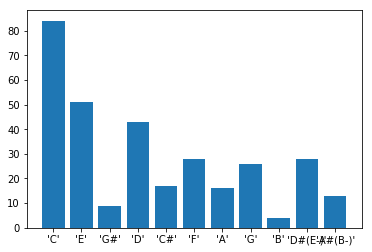

17


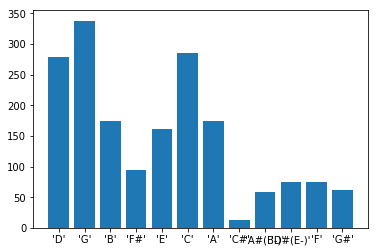

18


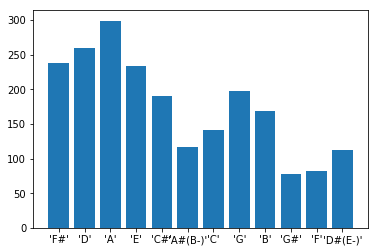

19


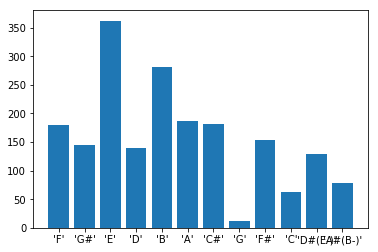

20


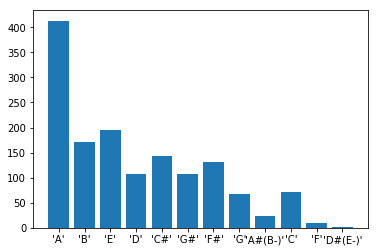

21


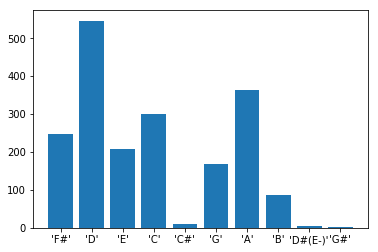

22


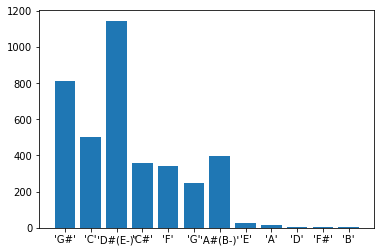

23


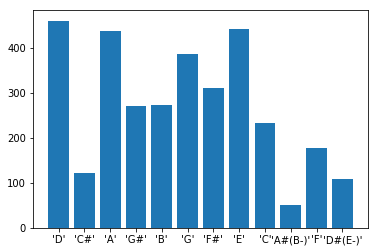

24


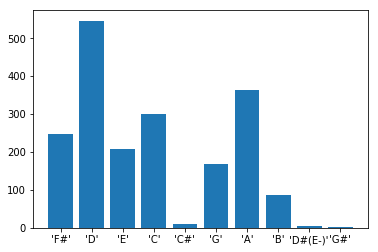

25


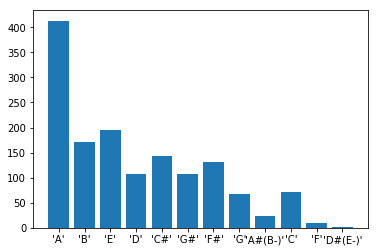

26


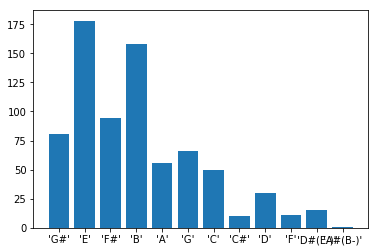

27


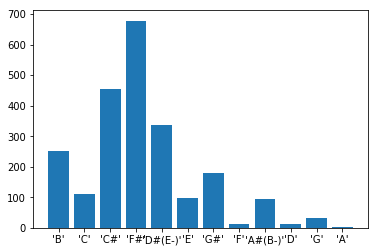

28


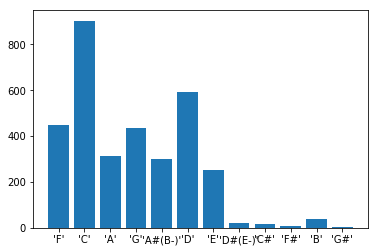

29


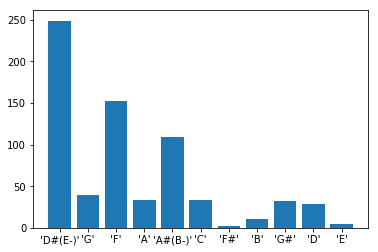

30


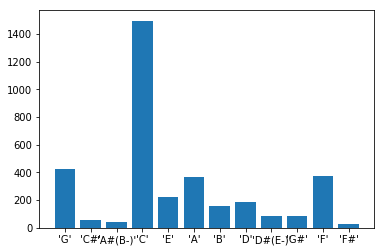

31


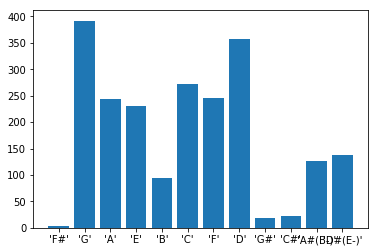

32


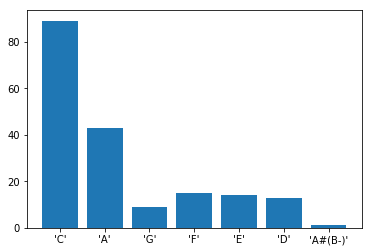

33


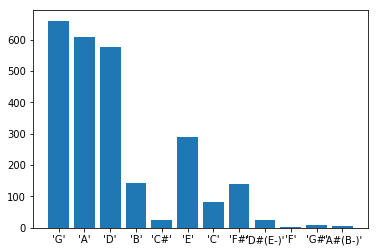

34


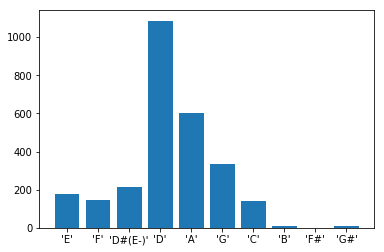

35


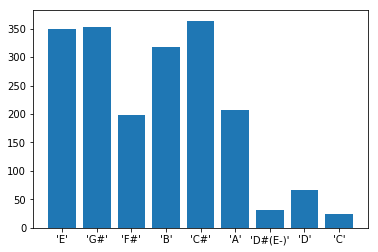

36


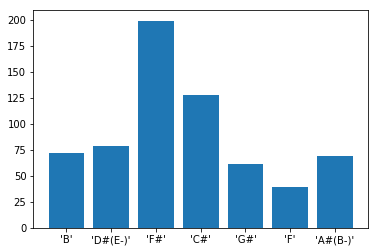

37


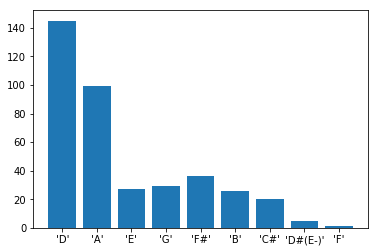

38


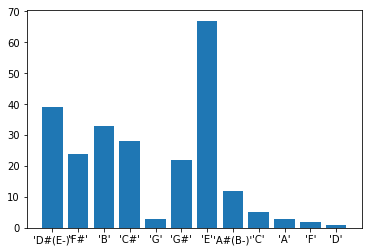

39


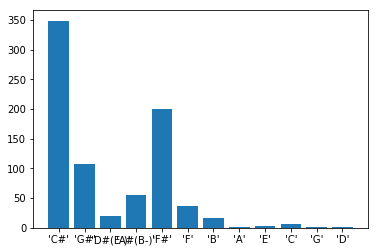

40


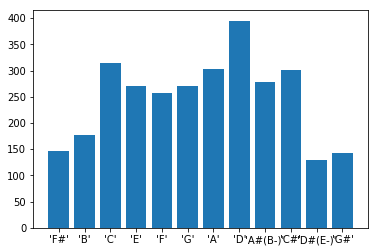

41


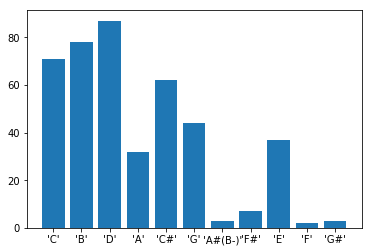

42


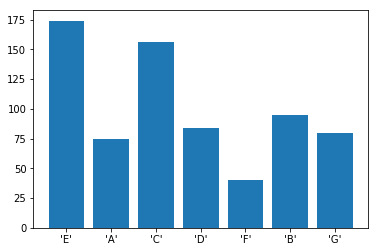

43


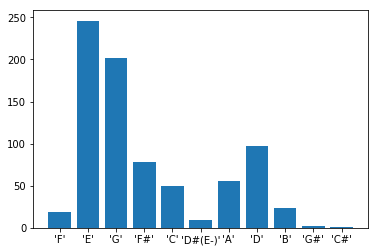

44


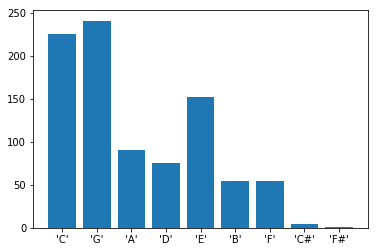

45


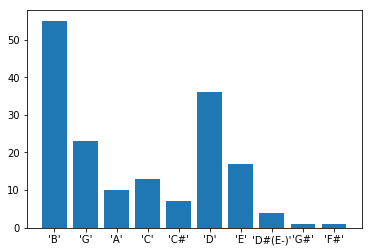

46


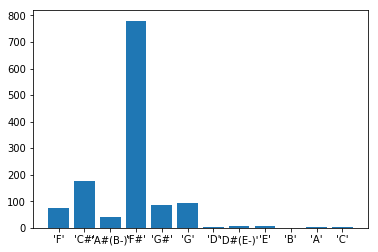

47


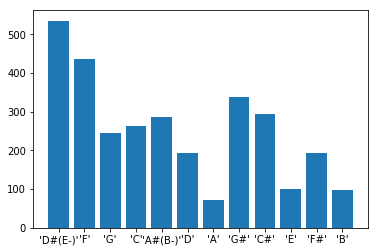

48


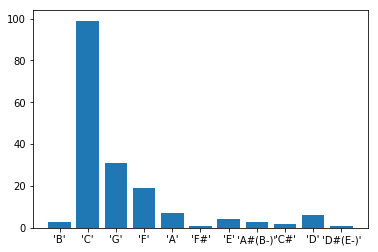

49


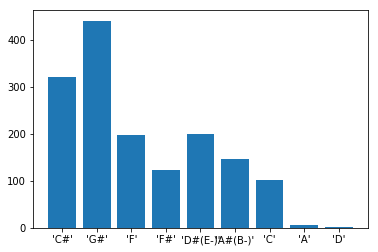

50


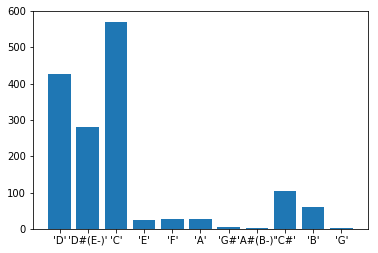

51


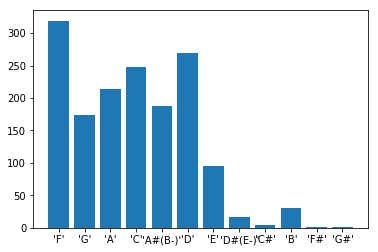

52


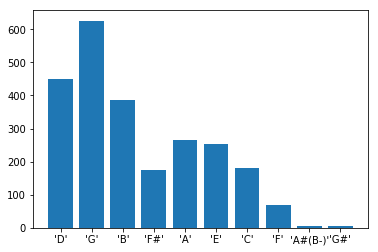

53


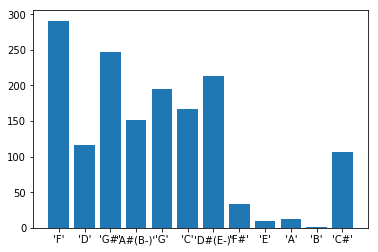

54


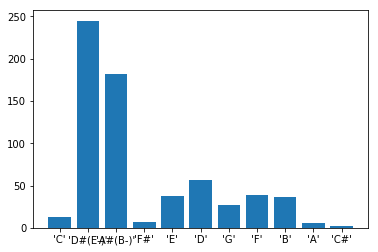

55


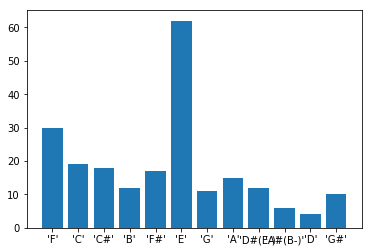

56


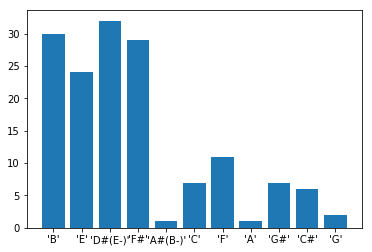

57


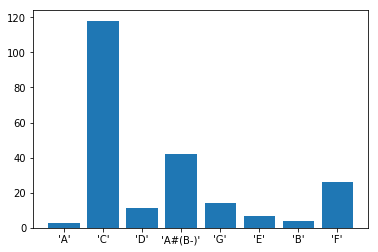

58


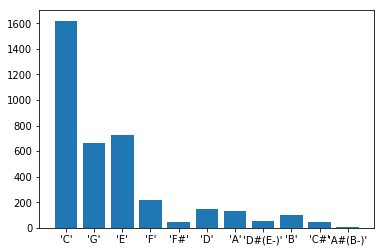

59


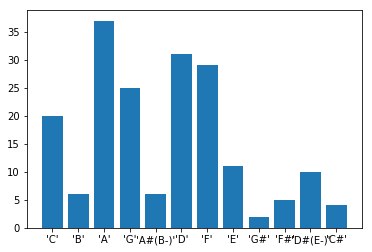

60


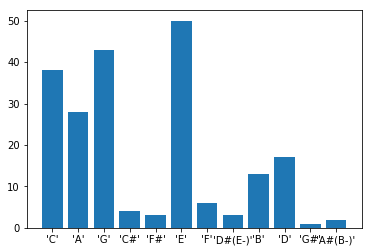

61


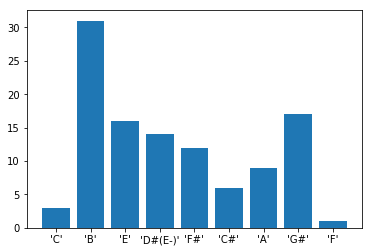

62


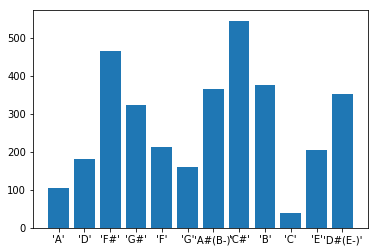

63


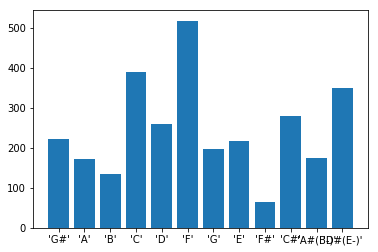

64


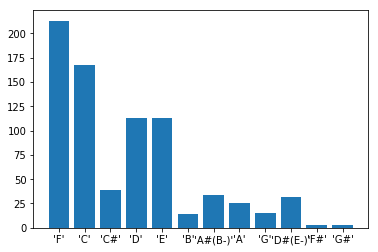

65


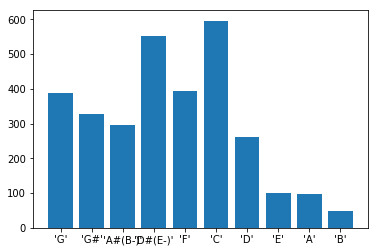

66


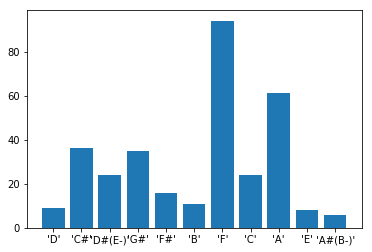

67


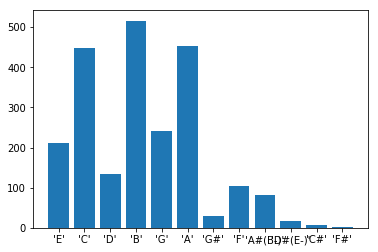

68


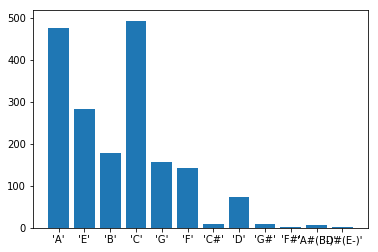

69


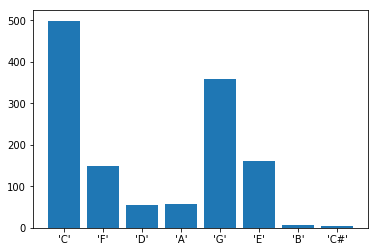

70


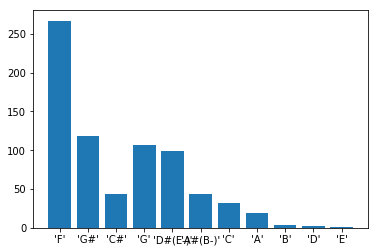

71


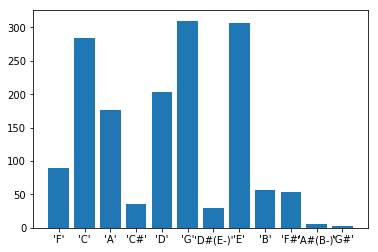

72


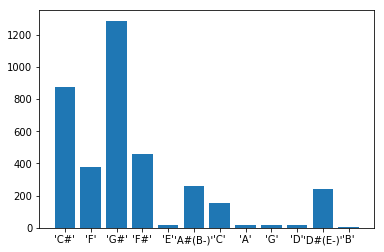

73


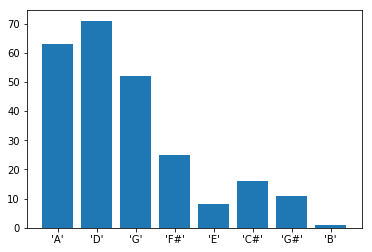

74


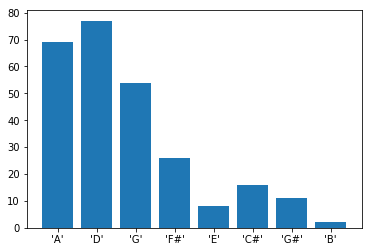

In [204]:
for idx in range(len(pitch)): 
    ngram_pitch = n_gram2(pitch[idx], 1)
    plt.bar(range(len(ngram_pitch)), list(ngram_pitch.values()), align='center')
    plt.xticks(range(len(ngram_pitch)), (ngram_pitch.keys()))
    print(idx)
    plt.show()

### Pitch progression in all dataset

In [228]:
## flatteren
flattened = [val for sublist in pitch for val in sublist]
perfect_, same_, non_ , big3_ , small3_ ,four_, whole_ = count_pattern(flattened, 1,0,2)
print("Perfect 5:", perfect_, '%')
print("Big three:",big3_, '%')
print("Small",small3_, '%')
print("Stable:",same_, '%')
print("Four:",four_, '%')
print("WholeTone:",whole_, '%')
print("Other",non_, '%')
print()

Perfect 5: 9.67 %
Big three: 5.28 %
Small 5.07 %
Stable: 35.07 %
Four: 9.78 %
WholeTone: 12.63 %
Other 22.5 %



### Pitch progression in each songs

In [424]:
for i in range(len(pitch)):
    perfect_, same_, non_ , big3_ , small3_ ,four_, whole_ = count_pattern(pitch[i], 1,0,2)
    print(i, sleeping_music[i])
    print("Perfect 5:", perfect_, '%')
    print("Big three:",big3_, '%')
    print("Small",small3_, '%')
    print("Stable:",same_, '%')
    print("Four:",four_, '%')
    print("WholeTone:",whole_, '%')
    print("Other",non_, '%')
    print()

0 1 小时 心灵音乐 学习  輕音樂 睡覺  睡眠音樂 水晶  放鬆音樂  純音樂 節奏.wav
Perfect 5: 10.41 %
Big three: 3.82 %
Small 4.71 %
Stable: 39.12 %
Four: 8.79 %
WholeTone: 11.45 %
Other 21.65 %

1 3小时放鬆的音樂  背景音樂  純音樂 輕快 水音  禪修音樂  輕音樂  心靈音樂.wav
Perfect 5: 9.42 %
Big three: 7.57 %
Small 3.37 %
Stable: 39.1 %
Four: 12.03 %
WholeTone: 6.58 %
Other 21.9 %

2 Relaxing Piano Music Sleep Music Water Sounds Relaxing Music Meditation Music ★47🍀.wav
Perfect 5: 10.23 %
Big three: 3.32 %
Small 7.29 %
Stable: 16.11 %
Four: 14.19 %
WholeTone: 19.05 %
Other 29.67 %

3 [無廣告版] 讀書工作好心情！放鬆舒壓鋼琴和大自然音律 - 5 HOURS RELAX STUDYING MUSIC FOR CONCENTRATION.wav
Perfect 5: 6.61 %
Big three: 5.79 %
Small 6.61 %
Stable: 30.58 %
Four: 7.44 %
WholeTone: 11.57 %
Other 30.99 %

4 m1.wav
Perfect 5: 12.25 %
Big three: 3.62 %
Small 1.61 %
Stable: 46.98 %
Four: 11.04 %
WholeTone: 7.48 %
Other 16.96 %

5 m10.wav
Perfect 5: 15.12 %
Big three: 3.38 %
Small 0.62 %
Stable: 52.88 %
Four: 14.75 %
WholeTone: 3.75 %
Other 9.38 %

6 m11.wav
Perfect 5: 10.52 %
Big thr

## Visualize

In [107]:
def plot_wordcloud(data, max_word):
    wordcloud = WordCloud(max_words=max_word, max_font_size=1500,background_color='black',width=2000, height=2000,margin=2).\
    generate_from_frequencies(data)
    plt.figure(figsize=(10,10))
    plt.tight_layout()
    plt.imshow(wordcloud)

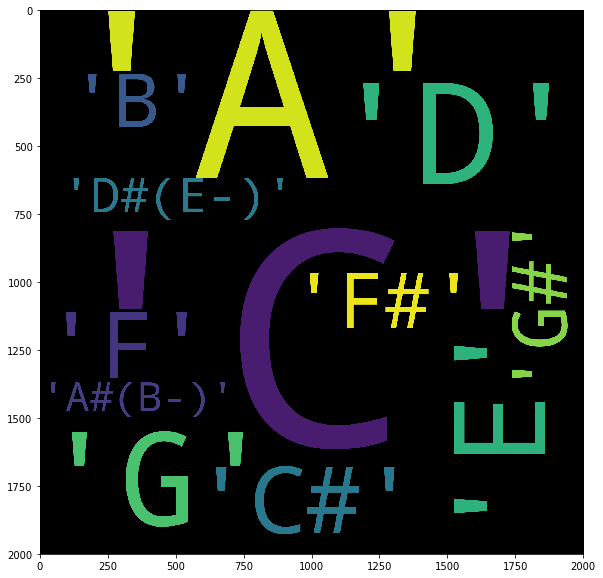

In [426]:
## pitch frequency
a = n_gram(pitch, 1)
plot_wordcloud(a,50)

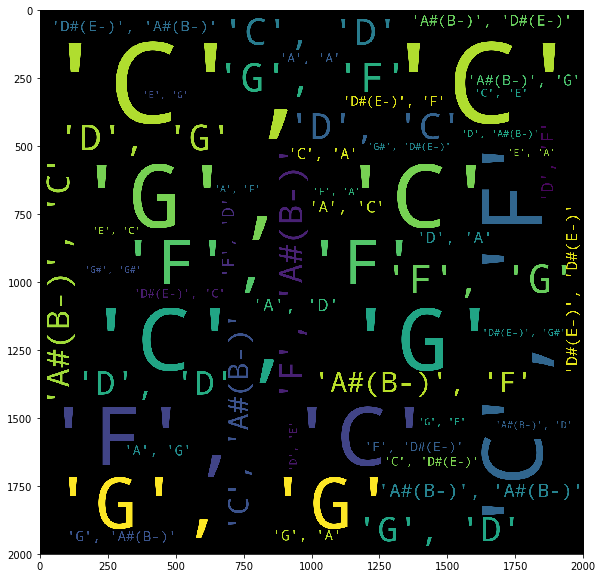

In [209]:
## chord frequency
a = n_gram(nor_chord,2)
plot_wordcloud(a,50)

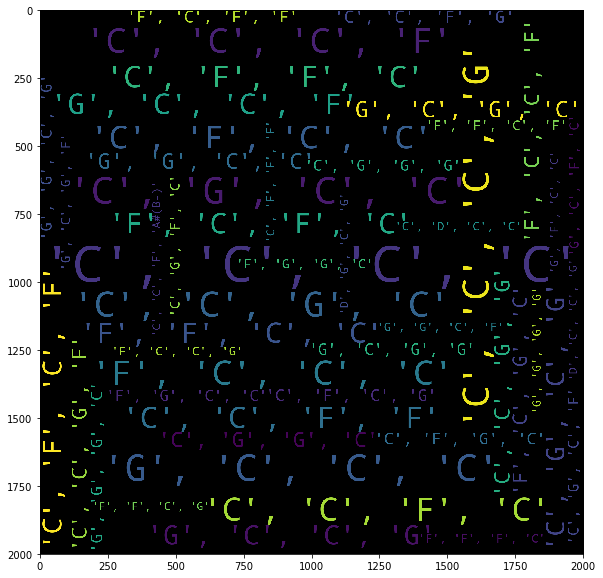

In [229]:
## chord frequency
a = n_gram(nor_chord,4)
plot_wordcloud(a,50)

### Analysis 2 phrase

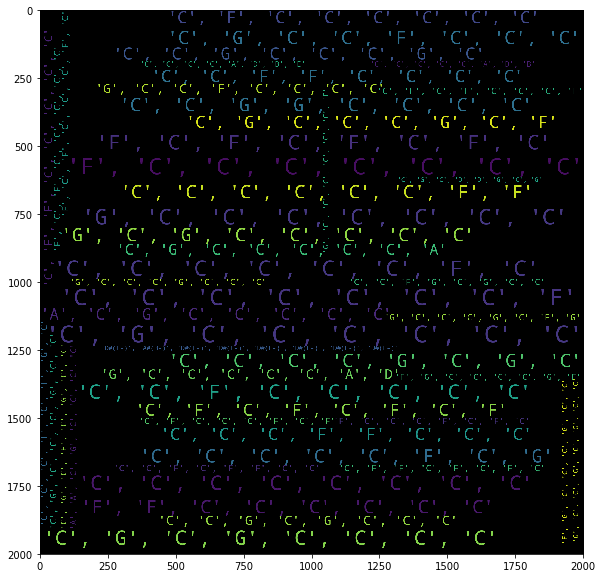

In [220]:
a = n_gram(nor_chord,8)
plot_wordcloud(a,50)

In [219]:
## sort by dict values or keys
def sort_dict_values(dictionary):
    sort_v = sorted(dictionary.items(), key=lambda kv: kv[1])
    return sort_v

def sort_dict_keys(dictionary):
    return [(k,dictionary[k]) for k in sorted(dictionary.keys())]

## ngram list to dictionary
def to_dict(list1, list2):
    tempk=[]; tempv=[]
    for i in range(len(list1)):
        tempk.append(list1[i])
        tempv.append(list2[i])
    result = dict(zip(tempk,tempv))
    return result

import re

def str_to_list(string):
    a = (string).replace("'", '[')
    a = a.split('[')
    result = []
    for i in range(int(len(a)/2)):
        result.append(a[2*i+1])
    return result

### Count 8 gram to see how chord changing in each phrase

In [221]:
ngram_key = []
# flattened = [val for sublist in sleeping_key for val in sublist]
for i in range(len(nor_chord)):
    for j in range(int(len(nor_chord[i])/8)):
        ngram_key.append(nor_chord[i][8*j:8*(j+1)])
count_ngram = dict([])
for i in range(len(ngram_key)):
     ngram_key[i] = (','.join(ngram_key[i]))
for item in ngram_key:
    if item in count_ngram:
        count_ngram[item] += 1  # value count
    else:
        count_ngram[item] = 1

In [222]:
len(count_ngram)

1458

In [223]:
sort_dict_values(count_ngram)[-20:]

[('F,F,C,E,C,C,F,F', 2),
 ('C,G,F,C,C,F,F,B', 2),
 ('A#(B-),A,C,C,C,C,F,B', 2),
 ('F,F,E,A,A#(B-),C,F,C', 2),
 ('C,F,F,F,F,F,C,C', 2),
 ('F,F,E,A#(B-),A,C,F,F', 2),
 ('A#(B-),A,F,C,F,A#(B-),G,F', 2),
 ('F,C,C,F,A,A#(B-),C,F', 2),
 ('C,C,G,F,D,C,G,C', 2),
 ('E,A#(B-),A#(B-),C,C,E,F,A#(B-)', 2),
 ('F,F,E,E,C,C,C,A#(B-)', 2),
 ('A#(B-),A#(B-),C,C,C,C,E,A#(B-)', 2),
 ('A#(B-),A#(B-),F,F,A#(B-),C,F,A', 2),
 ('E,C,A,F,A#(B-),E,F,C', 2),
 ('C,C,B,G,A#(B-),F,A,F', 2),
 ('F,A,C,F,F,C,C,F', 2),
 ('G,F,F,C,C,G,A#(B-),A#(B-)', 2),
 ('A#(B-),A#(B-),A,C,C,F,C,D', 2),
 ('F,G,C,C,C,C,G,F', 4),
 ('C,C,C,C,C,C,C,F', 4)]

In [224]:
c_list = []; uni_key = []
key_list = list(count_ngram.keys())
val_list = list(count_ngram.values())

for i in range(len(key_list)):
    count = 0
    key_list[i] = key_list[i].split(',') # str to list
    for j in range(len(key_list[i])):
        if j >=1:
            if key_list[i][j] == key_list[i][j-1]:
                count+=0
            else:
                count += 1
    c_list.append(count)
    uni_key.append(len(set(key_list[i]))) # count different
    key_list[i] = ','.join(key_list[i])

## format {key, (change times, count pattern, unique key)}
temp =[]
for i in range(len(c_list)):
    temp.append((c_list[i],val_list[i], uni_key[i]))

In [225]:
count_pat = to_dict(key_list, temp)

In [226]:
sort_dict_values(count_pat)

# c = 0
# for i in range(len(a)):
#     c+= a[i][1][1]
# c

[('F,F,C,C,C,C,C,C', (1, 1, 2)),
 ('C,C,C,C,C,C,A#(B-),A#(B-)', (1, 1, 2)),
 ('A#(B-),D#(E-),D#(E-),D#(E-),D#(E-),D#(E-),D#(E-),D#(E-)', (1, 1, 2)),
 ('F,F,F,F,F,F,A#(B-),A#(B-)', (1, 1, 2)),
 ('F,C,C,C,C,C,C,C', (1, 1, 2)),
 ('C,C,C,C,C,C,F,F', (1, 2, 2)),
 ('G,G,G,G,G,G,G,A', (1, 2, 2)),
 ('C,C,C,C,C,C,C,F', (1, 4, 2)),
 ('C,C,C,C,C,F,C,C', (2, 1, 2)),
 ('C,C,G,C,C,C,C,C', (2, 1, 2)),
 ('C,G,G,G,C,C,C,C', (2, 1, 2)),
 ('D,D,A,A,A,D,D,D', (2, 1, 2)),
 ('F,F,F,C,F,F,F,F', (2, 1, 2)),
 ('C,C,G,G,C,C,C,C', (2, 1, 2)),
 ('G,G,D,G,G,G,G,G', (2, 1, 2)),
 ('C,C,F,F,C,C,C,C', (2, 1, 2)),
 ('G,G,G,G,F,F,F,G', (2, 1, 2)),
 ('C,C,G,G,G,C,C,C', (2, 1, 2)),
 ('C,A#(B-),C,C,C,C,C,C', (2, 1, 2)),
 ('G,G,C,C,C,G,G,G', (2, 1, 2)),
 ('C,C,C,C,C,C,F,C', (2, 1, 2)),
 ('A#(B-),F,C,C,C,C,C,C', (2, 1, 3)),
 ('F,F,C,C,C,C,G,G', (2, 1, 3)),
 ('A,A,E,E,D,D,D,D', (2, 1, 3)),
 ('A#(B-),A#(B-),F,C,C,C,C,C', (2, 1, 3)),
 ('G,G,C,C,C,C,C,F', (2, 1, 3)),
 ('A,A,G,D,D,D,D,D', (2, 1, 3)),
 ('D#(E-),C,C,C,C,A#(B-),A#(B

### Unused code

In [ ]:
# o_env = librosa.onset.onset_strength(y1, sr=sr)
# times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
# onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

# import matplotlib.pyplot as plt
# D = np.abs(librosa.stft(y1))
# plt.figure()
# ax1 = plt.subplot(2, 1, 1)
# librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
#                           x_axis='time', y_axis='log')
# plt.title('Power spectrogram')
# plt.subplot(2, 1, 2, sharex=ax1)
# plt.plot(times, o_env, label='Onset strength')
# plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
#             linestyle='--', label='Onsets')
# plt.axis('tight')
# plt.legend(frameon=True, fram1ealpha=0.75)

In [130]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(15, 5))
# librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
# plt.colorbar()
# plt.title('Chromagram')
# plt.tight_layout()

In [ ]:
# ## split audio
# def chunk_wav(file, chunk_ms,folder, title):
#     chunks = make_chunks(file, chunk_ms)
#     # Export all of the individual chunks as wav files
#     for i, chunk in enumerate(chunks):
#         chunk_name = os.path.join("./test", folder,"{0}_chunk{1}.wav".format(title, i))
#         librosa.output.write_wav(chunk_name, chunk, sr)


In [170]:
# def n_gram(key_list, ngram):
#     k_list = [[word for word in line.split(",")] for line in key_list]
#     flattened = [val for sublist in k_list for val in sublist]
#     ngram_key = []
#     for i in range(int(len(flattened)/ngram)):
#         ngram_key.append(flattened[ngram*i : ngram*(i+1)])
#     count_ary = [[x,ngram_key.count(x)] for x in (ngram_key)]
#     unique = []
#     for item in count_ary:
#         if item not in unique:
#             unique.append(item)
#     unique = sorted(unique, key=lambda x:x[1], reverse = True)
#     return unique